In [10]:
import wrapper
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
from keras.layers import Dropout
import numpy as np
import dtw_cluster as dtw
import generateTechnicalIndicators as gti
import time
%matplotlib inline

In [11]:

def preprocessData(country, code):
    
    #Input dataset for all three cluster
    
    df_allCountry, df_allEvent, country_list, cameoCodes = dtw.load_data(country, code)
    df_allCountry.fillna(0, inplace=True)
    df_allEvent.fillna(0, inplace=True)
    
    #ClusterOne
    technicalIndicators = gti.getIndicators()
    
    #ClusterTwo
    country_cluster = dtw.cluster_two(df_allCountry, country_list, code)
    
    #ClusterThree
    event_cluster = dtw.cluster_three(df_allEvent, cameoCodes, country)
    
    
    #get similar event
    similar_event = []
    EventClusterValue = event_cluster[str(code)]
    for cd in cameoCodes:
        if event_cluster[cd] == EventClusterValue:
            similar_event.append(cd)
        
    #get data for similar events
    print("Preparing dataset for similar cameo codes:", similar_event)
    allSimilarEventData = []
    for event in similar_event:
        df = wrapper.countryWise_specificEvent(country, event)
        df = df.NumMentions
        allSimilarEventData.append(df)
        
    
    
    #get similar country
    similar_country = []
    CountryClusterValue = country_cluster[country]
    for cntry in country_list:
        try:
            if country_cluster[cntry] == CountryClusterValue:
                similar_country.append(cntry)
        except:
            pass
    
    #get data for similar countries
    print("Preparing dataset for similar countries: ", similar_country)
    allSimilarCountryData = []
    for cntry in similar_country:
        df = wrapper.countryWise_specificEvent(cntry, code)
        df = df.NumMentions
        allSimilarCountryData.append(df)
    
    return technicalIndicators, allSimilarCountryData, allSimilarEventData


In [12]:

def create_data(df, lag_days, label, country, code):
    if label == 'allSimilarCountry':
        y_df = wrapper.countryWise_specificEvent(country,code).NumMentions
    
    dataX, dataY = [], []
    
    for i in range(len(df)-lag_days-1):
        a = df[i:(i+lag_days)]
        dataX.append(np.array(a))
        
        if label == 'technicalIndicators':
            dataY.append(df.iloc[i+lag_days].avgNumMentions) #avgNumMentions
        elif label == 'allSimilarCountry':
            dataY.append(y_df.iloc[i+lag_days])
        
    return np.array(dataX), np.array(dataY)


In [13]:
#LSTM for cluster 1(Technical Indicators)
def indicator_lstm(technicalIndicators, country, code, plot=True):
    df = technicalIndicators
    total_days = len(df)
    
    train_len = int(0.75*total_days)
    train = df[:train_len]
    test = df[train_len:]
    
    X_train, y_train = create_data(train, 6, label='technicalIndicators', country=country, code=code)
    X_test, y_test = create_data(test, 6, label='technicalIndicators', country=country, code=code)
    
    batch_size = 8
    epochs = 50
    
    model = Sequential()
    model.add(LSTM(512, batch_input_shape=(None, 6, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss= 'logcosh', optimizer= 'Adagrad')
    history = model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
    
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    
    if plot:
        train_NumMentions = df.avgNumMentions
    
        X_actual_data, y_actual_data = create_data(df, 6, label='technicalIndicators', country=country, code=code)
        predicted_whole_series = model.predict(X_actual_data)
        
        plt.figure(figsize=(12,7))
        plt.plot(predicted_whole_series, c='g', label="Predicted whole series")
        plt.plot(train_NumMentions, c='r', label="Training series")
        plt.title('Actual training vs whole series as prediction')
        plt.legend(loc='best')
    
    

    return testPredict


In [14]:
country = 'US'
code = '14'
technicalIndicators, allSimilarCountryData, allSimilarEventData = preprocessData(country, code)

Preparing dataset for similar cameo codes: ['10', '13', '14', '15', '16', '18', '20']
Preparing dataset for similar countries:  ['US']


/home/saurabh/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Training on technical indicator:


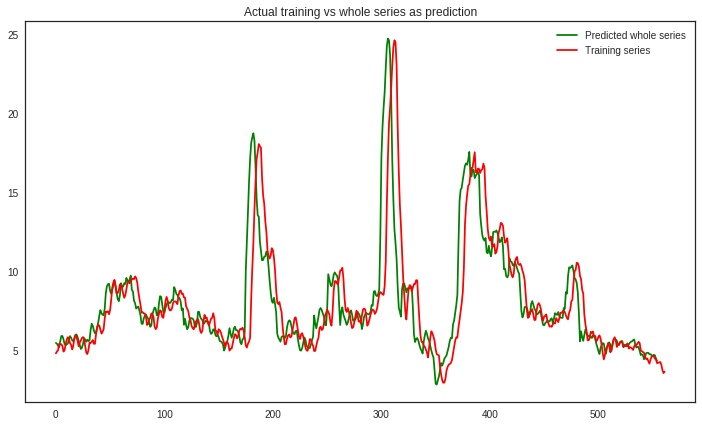

In [15]:
print("Training on technical indicator:")
indicator_pred = indicator_lstm(technicalIndicators, country, code, plot=True)